In This small project I use some webscraping to get news headlines for companys and perform a Sentiment Analysis based on the headline of the news. The website I scrape data from is finviz which is a very reliable news source.  

In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import nltk
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# If you havent download vader lexicon you can download it by using 
# nltk.download("vader_lexicon")

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
finviz_url = "https://finviz.com/quote.ashx?t="
tickers = ["AMZN", "AMD", "NVDA"]

First we need to create an empty dictionary where we can store our web scraped news tables which will then be parsed to only get the news headlines and date + time. Here we use BeautifulSoup and Request to get all the html from the website.

In [9]:
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    
    req = Request(url=url, headers={"user-agent": "my-app"})
    response = urlopen(req)
    
    html = BeautifulSoup(response, "html")
    news_table = html.find(id="news-table")
    news_tables[ticker] = news_table
    

In [10]:
parsed_data = []
date = None
for ticker, news_table in news_tables.items():
    
    for row in news_table.findAll("tr"):
        
        title = row.a.text
        
        date_data = row.td.text.split(" ")
        
        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        parsed_data.append([ticker, date, time, title])
        
print(parsed_data[:3])

[['AMZN', 'Jan-15-21', '06:00AM\xa0\xa0', 'Biden is the right man to address inequality: Democratic megadonor'], ['AMZN', 'Jan-15-21', '05:00AM\xa0\xa0', 'Amazon Keeps Buying Pricey Jets After Promising a Drone Fleet'], ['AMZN', 'Jan-14-21', '09:08PM\xa0\xa0', 'Amazon faces class-action lawsuit over eBook pricing']]


In [11]:
df = pd.DataFrame(parsed_data, columns = ["ticker", "date", "time", "title"])
df.head()

,ticker,date,time,title
0,AMZN,Jan-15-21,06:00AM,Biden is the right man to address inequality: ...
1,AMZN,Jan-15-21,05:00AM,Amazon Keeps Buying Pricey Jets After Promisin...
2,AMZN,Jan-14-21,09:08PM,Amazon faces class-action lawsuit over eBook p...
3,AMZN,Jan-14-21,05:48PM,Dow Jones Futures: $1.9 Trillion Biden Stimulu...
4,AMZN,Jan-14-21,05:01PM,The Stock Market Had a Better Day Than it Seem...


Now that we have our dataframe with the tickers, date, time and the news headline we can use from vader lexicon the SentimentIntensityAnalyzer which calculates based on the words used in the news headline if the news has a positive or negative sentiment. The compound is a aggregated value which is calculated on the negativ, neutral and positive score of the news headline

In [12]:
vader = SentimentIntensityAnalyzer()

In [13]:
f = lambda title:vader.polarity_scores(title)["compound"]

In [14]:
df["compound"] = df["title"].apply(f)
df["date"] = pd.to_datetime(df.date).dt.date

In [19]:
df.head(7)

,ticker,date,time,title,compound
0,AMZN,2021-01-15,06:00AM,Biden is the right man to address inequality: ...,0.0000
1,AMZN,2021-01-15,05:00AM,Amazon Keeps Buying Pricey Jets After Promisin...,0.5267
2,AMZN,2021-01-14,09:08PM,Amazon faces class-action lawsuit over eBook p...,-0.0516
3,AMZN,2021-01-14,05:48PM,Dow Jones Futures: $1.9 Trillion Biden Stimulu...,0.0000
4,AMZN,2021-01-14,05:01PM,The Stock Market Had a Better Day Than it Seem...,0.6597
5,AMZN,2021-01-14,04:31PM,"Virgin Galactic Rival Blue Origin Gets 'Very, ...",0.0000
6,AMZN,2021-01-14,04:01PM,These Big Stocks Go Both Sides While Others Pi...,-0.6249


In [21]:
df.shape

(300, 5)

In [16]:
mean_df = df.groupby(["ticker", "date"]).mean()
mean_df = mean_df.unstack()
mean_df = mean_df.xs("compound", axis="columns").transpose()
mean_df

ticker,AMD,AMZN,NVDA
date,,,
2020-12-21,-0.771700,NaN,NaN
2020-12-22,0.221725,NaN,NaN
2020-12-23,-0.131675,NaN,NaN
2020-12-24,-0.263350,NaN,NaN
2020-12-26,0.115500,NaN,NaN
2020-12-27,0.636900,NaN,NaN
2020-12-28,0.062500,NaN,NaN
2020-12-29,0.004740,NaN,NaN
2020-12-30,-0.113150,NaN,0.056667


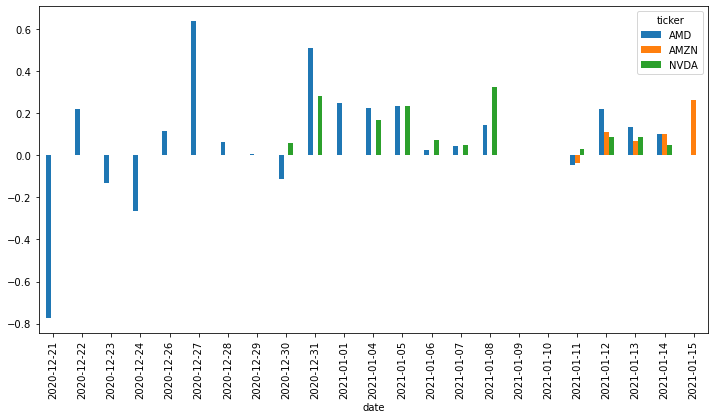

In [18]:

mean_df.plot(kind="bar", figsize=(12,6))
plt.show()